# Simple NN Regression Model
**Goal**: Use metrological data for the year to predict the crop yield for that year.

**Run instructions**:
- in collab, change ``GOOGLE_DRIVE_PATH`` to appropriate directory structure (marked with ``# TODO``)
- select crop to predict yield for by changing crop variable in data download section (marked with ``# TODO``)
- *optional*: update hyperparameters in section ``# Set hyper-parameters``
- then just select 'Run all', results + plots will print at bottom

**Possible architecture improvments**:
- Add more layers to simple NN
- Try transformer architecture

**Future code improvments**:
- Add Torchvision experiment tracking, etc.
- Refactor code: functionalize hyper-parameter tuning

**Improvements attempted**
1. Combine all crops into 1 data set with dummy variables for crop type => intial results worse (lower RMSE, ~26 without tuning)
2. Add ``asd_desc`` which describes the type of land in each county (make dummy variables, etc.) => helps very slightly (e.g. for Corn, RMSE goes down  1, to ~15 from ~16)
3. fine-tune hyperparameters (learning rate, hidden dimensions, batch size, weight decay, etc.) => random search better + faster than grid but neither much better than intuition (grid search actually worse when only given 10 epochs instead of 20)
  - to run grid search, set ```do_grid_search=true```
  - to run random search, set ```NUM_SEARCH``` to postive integer (e.g. 10)

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'DL/MMST-ViT-main'  # TODO change this
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['models_pvt.py', 'main_finetune_mmst_vit.py', 'models_mmst_vit.py', 'attention.py', 'README.md', 'LICENSE', 'requirements.txt', 'models_pvt_simclr.py', 'data', 'input', 'util', 'dataset', 'loss', 'config', '__pycache__', 'output_dir', 'main_pretrain_mmst_vit.py', 'gsheet2csv.ipynb', 'train_debug.ipynb', 'GridSearchSandbox.ipynb', 'mmst_vit_output', 'mmst_vit_logs', 'simple_model', "Abhishek's training.ipynb", 'mmst_vit_output_bs16_lr0.0001_wd0.01_we10', 'mmst_vit_logs_bs16_lr0.0001_wd0.01_we10', 'mmst_vit_output_bs16_lr0.0001_wd0.05_we10', 'mmst_vit_logs_bs16_lr0.0001_wd0.05_we10']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Running in google colab. Our path is `/content/drive/MyDrive/DL/MMST-ViT-main`


In [ ]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [ ]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [1]:
# load data - 1 crop
crop = 'Cotton' # TODO set as appropriate. Options= Corn, Cotton, Soybeans, WinterWheat
# 'region' will be 1 crop but includes include dummy columns for region,
# 'all_crops' has all 4 crops (identified by dummy cols) in 1 dataset
# default is 1 crop without dummy columns for region
dataset = True # TODO set as desired. Options = 'region', 'all_crops', 'default'

if dataset == 'region':
    df = pd.read_csv(f'{GOOGLE_DRIVE_PATH}/simple_model/monthly_{crop}_with_region.csv')
elif dataset == 'all_crops':
    df = pd.read_csv(f'{GOOGLE_DRIVE_PATH}/simple_model/all_crops.csv')
else:
  df = pd.read_csv(f'{GOOGLE_DRIVE_PATH}/simple_model/monthly_{crop}_model_data.csv')

# # to load 1 dataset with all 4 crops, identified by dummy columns
# df = pd.read_csv(f'{GOOGLE_DRIVE_PATH}/simple_model/all_crops.csv')

df.head()
X = df.drop(columns='yield').to_numpy()
y = df['yield'].to_numpy()

num_data_features = X.shape[1]
X.shape, y.shape, num_data_features

NameError: name 'pd' is not defined

In [ ]:
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(f'{X_train[0].shape=}')
print(f'{y_train[0]=}')

torch.Size([184, 117]) torch.Size([184, 1])
torch.Size([47, 117]) torch.Size([47, 1])
X_train[0].shape=torch.Size([117])
y_train[0]=tensor([960.])


In [ ]:
# turn into correct type format to be put into data loader
# based on pytorch docs
class CustomDataset(Dataset):
    def __init__(self, X_p, y_p, transform=None, target_transform=None):
        self.X = X_p
        self.y = y_p
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.y[idx]
        if self.transform:
            item = self.transform(item)
        if self.target_transform:
            label = self.target_transform(label)
        return item, label

train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader
# Setup batch size and number of workers
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader
next(iter(train_dataloader))
# # check ok
item, label = next(iter(train_dataloader))
print(f"Data shape: {item.shape} -> [batch_size, # features]")
print(f"Label shape: {label.shape}")

Data shape: torch.Size([4, 117]) -> [batch_size, # features]
Label shape: torch.Size([4, 1])


In [ ]:
class MyModel(nn.Module):
    """
    Model architecture is just basic to test code
    """
    def __init__(self, input_features: int, hidden_units: int, act_func=nn.ReLU()) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            act_func,
            # nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # act_func,
            nn.Linear(in_features=hidden_units, out_features=1)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [ ]:
# Training code adapted from: https://www.learnpytorch.io/

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)

    return train_loss

In [ ]:

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    return test_loss

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": [],
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        # # 4. Print out what's happening
        # if epoch % 5 == 0 or epoch == epochs - 1:
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# based on: https://gist.github.com/jamesr2323/33c67ba5ac29880171b63d2c7f1acdc5
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "test_loss": [...],
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title(f'Loss: {crop}')
    plt.xlabel('Epochs')
    plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1008.4020 | test_loss: 951.2336
Epoch: 1 | train_loss: 811.3092 | test_loss: 586.4404
Epoch: 2 | train_loss: 360.8354 | test_loss: 185.2132
Epoch: 3 | train_loss: 135.9842 | test_loss: 132.9093
Epoch: 4 | train_loss: 103.3097 | test_loss: 125.6083
Epoch: 5 | train_loss: 93.6645 | test_loss: 119.7235
Epoch: 6 | train_loss: 81.0919 | test_loss: 114.0624
Epoch: 7 | train_loss: 76.9484 | test_loss: 113.6391
Epoch: 8 | train_loss: 73.7736 | test_loss: 119.5731
Epoch: 9 | train_loss: 69.5495 | test_loss: 111.1454
Epoch: 10 | train_loss: 66.3503 | test_loss: 102.2124
Epoch: 11 | train_loss: 65.8549 | test_loss: 110.6455
Epoch: 12 | train_loss: 63.3745 | test_loss: 116.2839
Epoch: 13 | train_loss: 65.1520 | test_loss: 106.6528
Epoch: 14 | train_loss: 60.2342 | test_loss: 121.8363
Epoch: 15 | train_loss: 60.4442 | test_loss: 102.5308
Epoch: 16 | train_loss: 58.3190 | test_loss: 115.9867
Epoch: 17 | train_loss: 56.4186 | test_loss: 110.2220
Epoch: 18 | train_loss: 55.6987 

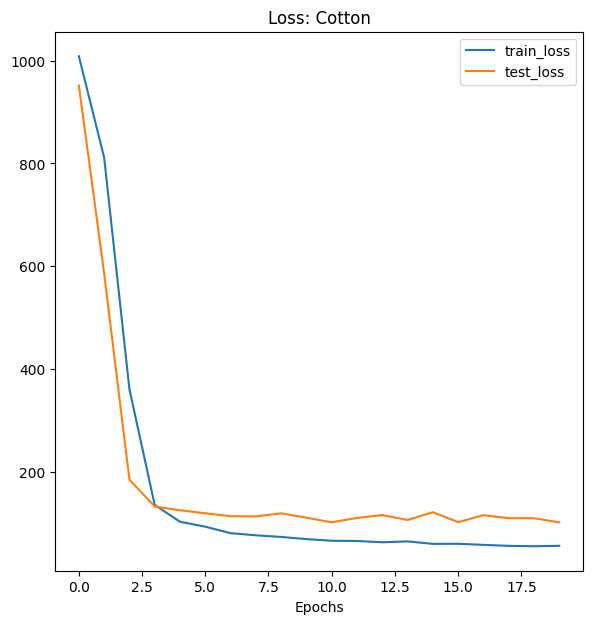

In [ ]:
# Set random seeds
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set hyper-parameters
# 3-layer NN
# Corn: best values after 10 epoch grid search {'HIDDEN_DIM': 100, 'learning_rate': 0.005, 'weight_decay': 0.001} => unstable test curve
# Corn: at 20 epochs smoother is: HIDDEN_DIM = 80, learning_rate = 0.001,  weight_decay= 0.01
# Cotton: random search result: RMSE=90.7 {'learning_rate': 0.0691, 'weight_decay': 0.07041, 'hidden_dim': 55, 'activation_func': SELU()}
# Soybeans: random search result: Best RMSE: 4.8, Best Config: {'learning_rate': 0.0051, 'weight_decay': 0.01141, 'hidden_dim': 55, 'activation_func': LeakyReLU(negative_slope=0.01)}
#               Best RMSE: 4.4, Best Config: {'learning_rate': 0.0151, 'weight_decay': 0.00211, 'hidden_dim': 25, 'activation_func': SELU()}

# 2-layer
# Soyeban Best RMSE: 5.05, Best Config: {'learning_rate': 0.0041, 'weight_decay': 0.03621, 'hidden_dim': 20, 'activation_func': ReLU()}
# Corn Best RMSE: 100.20, Best Config: {'learning_rate': 0.0691, 'weight_decay': 0.04521, 'hidden_dim': 75, 'activation_func': GELU(approximate='none')}
#Best RMSE: 16.58, Best Config: {'learning_rate': 0.0071, 'weight_decay': 0.03171, 'hidden_dim': 75, 'activation_func': SELU()}
# Best RMSE: 18.78, Best Config: {'learning_rate': 0.0021, 'weight_decay': 0.03291, 'hidden_dim': 90, 'activation_func': ReLU()}
# Best RMSE: 16.78, Best Config: {'learning_rate': 0.0141, 'weight_decay': 0.03801, 'hidden_dim': 35, 'activation_func': ReLU()}
# 3-layer: Best RMSE: 14.08, Best Config: {'learning_rate': 0.0141, 'weight_decay': 0.00201, 'hidden_dim': 65, 'activation_func': SELU()}

# Best RMSE: 104.5, Best Config: {'learning_rate': 0.0471, 'weight_decay': 0.04631, 'hidden_dim': 85, 'activation_func': GELU(approximate='none')}

# Best RMSE: 97.79, Best Config: {'learning_rate': 0.0481, 'weight_decay': 0.02621, 'hidden_dim': 50, 'activation_func': LeakyReLU(negative_slope=0.01)}
# Best RMSE at last epoch: 106.8, Best Config at last epoch: {'learning_rate': 0.0141, 'weight_decay': 0.04841, 'hidden_dim': 75, 'activation_func': SELU()}

# Best RMSE: 99.2, Best Config: {'learning_rate': 0.0151, 'weight_decay': 0.04051, 'hidden_dim': 45, 'activation_func': LeakyReLU(negative_slope=0.01)}

NUM_EPOCHS = 20
HIDDEN_DIM = 45 # corn: 80, cotton: 64, soybeans:80/55 winterwheat 80/65
learning_rate = 0.01 # corn: 0.001, cotton: 0.01 , soybeans 0.005, winterwheat  0.05
weight_decay= 0.05 # corn: 0.01, cotton: 0.1, spybeans: 0.01, winterwheat 0.05
activation_func = nn.LeakyReLU() #corn: nn.LeakyReLU(), cotton: nn.SELU(), soybeans: nn.ReLU()
# Setup model
model_0 = MyModel(num_data_features, HIDDEN_DIM, activation_func).to(device)

# Setup loss function and optimizer
loss_fn = RMSELoss() # nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model_0_results)

In [ ]:
NUM_EPOCHS = 10
do_grid_search = False
activation_func = nn.LeakyReLU()

hyperparam_grid = {
    'HIDDEN_DIM': [20, 64, 100],
    'learning_rate': [1e-2, 1e-3, 5e-3, 1e-4],
    'weight_decay': [0.1, 0.01, 0.05, 0.001],
    # 'activation_func': [nn.LeakyReLU(), nn.ReLU(), nn.SELU(), nn.GELU()]
}

if do_grid_search:
  best_rmse = float('inf')
  best_config = None
  best_rmse_last_epoch = float('inf')
  best_config_last_epoch = None
  for config in ParameterGrid(hyperparam_grid):
    print(f'Training with config: {config}')
    model_0 = MyModel(num_data_features, config['HIDDEN_DIM'], activation_func).to(device)

    # Setup loss function and optimizer
    loss_fn = RMSELoss() # nn.MSELoss()
    optimizer = torch.optim.Adam(params=model_0.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Train model_0
    model_0_results = train(model=model_0,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=NUM_EPOCHS)
    final_rmse = model_0_results['test_loss'][-1]
    min_rmse = min(model_0_results['test_loss'])
    if min_rmse < best_rmse:
        best_rmse = min_rmse
        best_config = config
    if final_rmse < best_rmse_last_epoch:
        best_rmse_last_epoch = final_rmse
        best_config_last_epoch = config

  print(f'Best RMSE: {best_rmse}, Best Config: {best_config}')
  print(f'Best RMSE at last epoch: {best_rmse_last_epoch}, Best Config at last epoch: {best_config_last_epoch}')
else:
  print('Set train_grid=True if you want to run the grid search. See cell above for results of 1 model.')


Set train_grid=True if you want to run the grid search. See cell above for results of 1 model.


In [ ]:
# If set NUM_SEARCH to 0, won't run
NUM_SEARCH = 30

# Random search
NUM_EPOCHS = 20
learning_rate_range = result = [x / 10000 for x in range(1, 1000, 10)]
weight_decay_rate_range = result = [x / 100000 for x in range(1, 10000, 10)]
hidden_dim_range = result = range(20, 100, 5)
activation_functions = [nn.LeakyReLU(), nn.ReLU(), nn.SELU(), nn.GELU()]

best_rmse = float('inf')
best_config = None
best_rmse_last_epoch = float('inf')
best_config_last_epoch = None

for i in range(NUM_SEARCH):
  learning_rate = random.choice(learning_rate_range)
  weight_decay = random.choice(weight_decay_rate_range)
  hidden_dim = random.choice(hidden_dim_range)
  activation_func = random.choice(activation_functions)
  config = {"learning_rate": learning_rate, 'weight_decay': weight_decay,
            'hidden_dim': hidden_dim, 'activation_func': activation_func }
  print(f"Run {i}: config is {config}")

  # Setup model
  model_0 = MyModel(num_data_features, hidden_dim, activation_func).to(device)

  # Setup loss function and optimizer
  loss_fn = RMSELoss() # nn.MSELoss()
  optimizer = torch.optim.Adam(params=model_0.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Train model_0
  model_0_results = train(model=model_0,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=NUM_EPOCHS)

  print(model_0_results)

  final_rmse = model_0_results['test_loss'][-1]
  min_rmse = min(model_0_results['test_loss'])
  if min_rmse < best_rmse:
      best_rmse = min_rmse
      best_config = config
  if final_rmse < best_rmse_last_epoch:
      best_rmse_last_epoch = final_rmse
      best_config_last_epoch = config

print(f'Best RMSE: {best_rmse}, Best Config: {best_config}')
print(f'Best RMSE at last epoch: {best_rmse_last_epoch}, Best Config at last epoch: {best_config_last_epoch}')





Run 0: config is {'learning_rate': 0.0831, 'weight_decay': 0.08261, 'hidden_dim': 60, 'activation_func': GELU(approximate='none')}


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 464.8997 | test_loss: 162.1801
Epoch: 1 | train_loss: 202.1023 | test_loss: 214.9585
Epoch: 2 | train_loss: 186.0080 | test_loss: 174.6358
Epoch: 3 | train_loss: 194.1919 | test_loss: 195.7517
Epoch: 4 | train_loss: 180.3929 | test_loss: 157.3689
Epoch: 5 | train_loss: 147.4864 | test_loss: 162.3556
Epoch: 6 | train_loss: 162.8509 | test_loss: 191.4724
Epoch: 7 | train_loss: 162.7277 | test_loss: 127.7976
Epoch: 8 | train_loss: 129.8785 | test_loss: 157.1129
Epoch: 9 | train_loss: 181.8131 | test_loss: 234.0883
Epoch: 10 | train_loss: 191.7265 | test_loss: 166.6028
Epoch: 11 | train_loss: 164.7976 | test_loss: 170.0510
Epoch: 12 | train_loss: 150.3490 | test_loss: 135.4542
Epoch: 13 | train_loss: 158.5164 | test_loss: 166.7938
Epoch: 14 | train_loss: 178.4590 | test_loss: 171.0425
Epoch: 15 | train_loss: 133.6707 | test_loss: 199.9041
Epoch: 16 | train_loss: 138.2223 | test_loss: 168.0762
Epoch: 17 | train_loss: 145.0570 | test_loss: 171.6223
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 546.2906 | test_loss: 226.1952
Epoch: 1 | train_loss: 143.7433 | test_loss: 142.4028
Epoch: 2 | train_loss: 118.4774 | test_loss: 147.9091
Epoch: 3 | train_loss: 130.7630 | test_loss: 196.0461
Epoch: 4 | train_loss: 136.4283 | test_loss: 167.7496
Epoch: 5 | train_loss: 147.6869 | test_loss: 142.0241
Epoch: 6 | train_loss: 133.0778 | test_loss: 162.0787
Epoch: 7 | train_loss: 133.9500 | test_loss: 167.9471
Epoch: 8 | train_loss: 114.5232 | test_loss: 180.9757
Epoch: 9 | train_loss: 119.8027 | test_loss: 146.5127
Epoch: 10 | train_loss: 105.4597 | test_loss: 130.0345
Epoch: 11 | train_loss: 113.7660 | test_loss: 140.1374
Epoch: 12 | train_loss: 123.5630 | test_loss: 197.0396
Epoch: 13 | train_loss: 118.1145 | test_loss: 118.2568
Epoch: 14 | train_loss: 125.5355 | test_loss: 158.5825
Epoch: 15 | train_loss: 117.9629 | test_loss: 134.4811
Epoch: 16 | train_loss: 107.2462 | test_loss: 146.1232
Epoch: 17 | train_loss: 110.9049 | test_loss: 124.7308
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 709.3186 | test_loss: 300.7928
Epoch: 1 | train_loss: 182.4800 | test_loss: 153.4465
Epoch: 2 | train_loss: 123.6096 | test_loss: 130.1069
Epoch: 3 | train_loss: 118.3484 | test_loss: 155.8912
Epoch: 4 | train_loss: 103.1193 | test_loss: 137.8995
Epoch: 5 | train_loss: 105.6752 | test_loss: 137.3064
Epoch: 6 | train_loss: 111.8874 | test_loss: 171.4938
Epoch: 7 | train_loss: 112.1141 | test_loss: 177.7799
Epoch: 8 | train_loss: 110.4173 | test_loss: 141.5268
Epoch: 9 | train_loss: 100.9974 | test_loss: 134.0258
Epoch: 10 | train_loss: 119.7054 | test_loss: 162.2276
Epoch: 11 | train_loss: 97.9466 | test_loss: 128.5172
Epoch: 12 | train_loss: 104.1262 | test_loss: 119.6034
Epoch: 13 | train_loss: 91.1233 | test_loss: 117.4597
Epoch: 14 | train_loss: 92.7065 | test_loss: 155.5776
Epoch: 15 | train_loss: 111.5109 | test_loss: 122.4685
Epoch: 16 | train_loss: 112.4558 | test_loss: 224.8126
Epoch: 17 | train_loss: 111.8098 | test_loss: 155.9404
Epoch: 18 | train_loss:

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 736.5032 | test_loss: 243.6531
Epoch: 1 | train_loss: 157.9326 | test_loss: 171.6166
Epoch: 2 | train_loss: 116.8527 | test_loss: 168.8170
Epoch: 3 | train_loss: 131.8716 | test_loss: 207.1995
Epoch: 4 | train_loss: 130.4703 | test_loss: 165.9296
Epoch: 5 | train_loss: 119.4977 | test_loss: 137.2154
Epoch: 6 | train_loss: 130.1819 | test_loss: 131.3681
Epoch: 7 | train_loss: 111.0308 | test_loss: 163.6364
Epoch: 8 | train_loss: 112.0070 | test_loss: 138.9721
Epoch: 9 | train_loss: 99.2870 | test_loss: 142.8939
Epoch: 10 | train_loss: 105.6737 | test_loss: 133.5468
Epoch: 11 | train_loss: 97.7785 | test_loss: 140.5824
Epoch: 12 | train_loss: 122.2059 | test_loss: 191.7534
Epoch: 13 | train_loss: 127.5427 | test_loss: 131.1069
Epoch: 14 | train_loss: 116.9068 | test_loss: 129.2995
Epoch: 15 | train_loss: 105.5196 | test_loss: 156.2108
Epoch: 16 | train_loss: 112.3918 | test_loss: 169.1632
Epoch: 17 | train_loss: 101.0609 | test_loss: 149.0124
Epoch: 18 | train_loss

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 479.9058 | test_loss: 209.5236
Epoch: 1 | train_loss: 182.4725 | test_loss: 168.5326
Epoch: 2 | train_loss: 180.3178 | test_loss: 228.5576
Epoch: 3 | train_loss: 152.8824 | test_loss: 188.0340
Epoch: 4 | train_loss: 175.3714 | test_loss: 215.5585
Epoch: 5 | train_loss: 163.6198 | test_loss: 170.3948
Epoch: 6 | train_loss: 143.2501 | test_loss: 171.0874
Epoch: 7 | train_loss: 152.6087 | test_loss: 261.6626
Epoch: 8 | train_loss: 187.8753 | test_loss: 216.1449
Epoch: 9 | train_loss: 155.4686 | test_loss: 173.4561
Epoch: 10 | train_loss: 169.0052 | test_loss: 171.7089
Epoch: 11 | train_loss: 135.1932 | test_loss: 186.1449
Epoch: 12 | train_loss: 166.6220 | test_loss: 173.5048
Epoch: 13 | train_loss: 171.0428 | test_loss: 156.4532
Epoch: 14 | train_loss: 136.7244 | test_loss: 125.1211
Epoch: 15 | train_loss: 148.6228 | test_loss: 177.1193
Epoch: 16 | train_loss: 155.5660 | test_loss: 169.3699
Epoch: 17 | train_loss: 127.7000 | test_loss: 177.9812
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 475.4084 | test_loss: 222.0905
Epoch: 1 | train_loss: 234.3867 | test_loss: 145.7420
Epoch: 2 | train_loss: 169.8978 | test_loss: 180.5399
Epoch: 3 | train_loss: 204.7583 | test_loss: 178.5730
Epoch: 4 | train_loss: 177.8355 | test_loss: 185.2238
Epoch: 5 | train_loss: 184.5677 | test_loss: 147.1716
Epoch: 6 | train_loss: 150.6848 | test_loss: 146.4364
Epoch: 7 | train_loss: 144.7091 | test_loss: 151.6890
Epoch: 8 | train_loss: 158.2922 | test_loss: 249.7529
Epoch: 9 | train_loss: 169.9624 | test_loss: 179.2061
Epoch: 10 | train_loss: 157.2658 | test_loss: 228.1346
Epoch: 11 | train_loss: 154.1125 | test_loss: 113.1454
Epoch: 12 | train_loss: 127.9906 | test_loss: 180.6347
Epoch: 13 | train_loss: 185.5560 | test_loss: 148.2259
Epoch: 14 | train_loss: 144.9198 | test_loss: 152.9663
Epoch: 15 | train_loss: 134.5286 | test_loss: 183.6104
Epoch: 16 | train_loss: 146.3639 | test_loss: 222.2789
Epoch: 17 | train_loss: 175.6738 | test_loss: 209.3816
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 671.0266 | test_loss: 310.7060
Epoch: 1 | train_loss: 172.8593 | test_loss: 133.9993
Epoch: 2 | train_loss: 141.0925 | test_loss: 132.7119
Epoch: 3 | train_loss: 119.8289 | test_loss: 153.7805
Epoch: 4 | train_loss: 128.9244 | test_loss: 163.9163
Epoch: 5 | train_loss: 115.5621 | test_loss: 124.2171
Epoch: 6 | train_loss: 101.4941 | test_loss: 143.9895
Epoch: 7 | train_loss: 111.0113 | test_loss: 154.5055
Epoch: 8 | train_loss: 125.9509 | test_loss: 128.9317
Epoch: 9 | train_loss: 128.3449 | test_loss: 161.1927
Epoch: 10 | train_loss: 113.8767 | test_loss: 150.5575
Epoch: 11 | train_loss: 110.0450 | test_loss: 150.3421
Epoch: 12 | train_loss: 113.2491 | test_loss: 134.7909
Epoch: 13 | train_loss: 111.0310 | test_loss: 134.0459
Epoch: 14 | train_loss: 109.5653 | test_loss: 147.0931
Epoch: 15 | train_loss: 113.8880 | test_loss: 139.5555
Epoch: 16 | train_loss: 117.1229 | test_loss: 135.0002
Epoch: 17 | train_loss: 108.3070 | test_loss: 160.5442
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 434.4718 | test_loss: 308.6473
Epoch: 1 | train_loss: 264.2423 | test_loss: 295.4791
Epoch: 2 | train_loss: 208.6439 | test_loss: 158.6143
Epoch: 3 | train_loss: 180.5693 | test_loss: 228.6657
Epoch: 4 | train_loss: 193.6753 | test_loss: 197.5717
Epoch: 5 | train_loss: 208.9187 | test_loss: 156.0923
Epoch: 6 | train_loss: 209.0115 | test_loss: 217.0032
Epoch: 7 | train_loss: 172.0035 | test_loss: 318.1104
Epoch: 8 | train_loss: 198.7647 | test_loss: 116.6892
Epoch: 9 | train_loss: 158.3894 | test_loss: 140.0952
Epoch: 10 | train_loss: 145.4592 | test_loss: 187.7426
Epoch: 11 | train_loss: 165.2519 | test_loss: 173.7010
Epoch: 12 | train_loss: 138.6172 | test_loss: 212.8126
Epoch: 13 | train_loss: 172.1473 | test_loss: 170.1170
Epoch: 14 | train_loss: 146.9608 | test_loss: 187.7288
Epoch: 15 | train_loss: 163.0841 | test_loss: 190.7758
Epoch: 16 | train_loss: 130.4903 | test_loss: 159.3179
Epoch: 17 | train_loss: 139.9900 | test_loss: 158.4440
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 560.6730 | test_loss: 264.0001
Epoch: 1 | train_loss: 157.4811 | test_loss: 172.8979
Epoch: 2 | train_loss: 109.4654 | test_loss: 123.6908
Epoch: 3 | train_loss: 114.4704 | test_loss: 110.4467
Epoch: 4 | train_loss: 101.8603 | test_loss: 134.9665
Epoch: 5 | train_loss: 131.4801 | test_loss: 151.9534
Epoch: 6 | train_loss: 133.5896 | test_loss: 177.9866
Epoch: 7 | train_loss: 106.6430 | test_loss: 180.7719
Epoch: 8 | train_loss: 124.8175 | test_loss: 131.7053
Epoch: 9 | train_loss: 99.6776 | test_loss: 131.6069
Epoch: 10 | train_loss: 93.3899 | test_loss: 117.4222
Epoch: 11 | train_loss: 119.0435 | test_loss: 157.4210
Epoch: 12 | train_loss: 122.6883 | test_loss: 167.9786
Epoch: 13 | train_loss: 117.7965 | test_loss: 156.8251
Epoch: 14 | train_loss: 117.0147 | test_loss: 172.3467
Epoch: 15 | train_loss: 106.2184 | test_loss: 121.2831
Epoch: 16 | train_loss: 97.0894 | test_loss: 137.6653
Epoch: 17 | train_loss: 129.8863 | test_loss: 117.0678
Epoch: 18 | train_loss:

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 707.6875 | test_loss: 223.6623
Epoch: 1 | train_loss: 185.4417 | test_loss: 160.3539
Epoch: 2 | train_loss: 136.4169 | test_loss: 142.3407
Epoch: 3 | train_loss: 120.3820 | test_loss: 156.6570
Epoch: 4 | train_loss: 123.3617 | test_loss: 165.9709
Epoch: 5 | train_loss: 134.9615 | test_loss: 202.9710
Epoch: 6 | train_loss: 144.2193 | test_loss: 143.4524
Epoch: 7 | train_loss: 120.6966 | test_loss: 133.9360
Epoch: 8 | train_loss: 140.6362 | test_loss: 119.0515
Epoch: 9 | train_loss: 123.9864 | test_loss: 144.3795
Epoch: 10 | train_loss: 111.5635 | test_loss: 116.2435
Epoch: 11 | train_loss: 106.3008 | test_loss: 136.5430
Epoch: 12 | train_loss: 116.3518 | test_loss: 146.7423
Epoch: 13 | train_loss: 130.0102 | test_loss: 189.0679
Epoch: 14 | train_loss: 128.9368 | test_loss: 157.3104
Epoch: 15 | train_loss: 108.4645 | test_loss: 160.2692
Epoch: 16 | train_loss: 113.0754 | test_loss: 136.1358
Epoch: 17 | train_loss: 133.1951 | test_loss: 173.4072
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 976.5943 | test_loss: 857.1231
Epoch: 1 | train_loss: 551.6209 | test_loss: 344.4454
Epoch: 2 | train_loss: 190.6108 | test_loss: 175.9331
Epoch: 3 | train_loss: 117.7490 | test_loss: 138.9124
Epoch: 4 | train_loss: 99.9863 | test_loss: 133.6457
Epoch: 5 | train_loss: 86.2612 | test_loss: 141.1017
Epoch: 6 | train_loss: 83.6197 | test_loss: 128.9323
Epoch: 7 | train_loss: 75.6711 | test_loss: 120.3147
Epoch: 8 | train_loss: 72.1064 | test_loss: 131.3255
Epoch: 9 | train_loss: 70.7657 | test_loss: 121.6660
Epoch: 10 | train_loss: 73.7346 | test_loss: 117.4373
Epoch: 11 | train_loss: 70.2395 | test_loss: 120.3389
Epoch: 12 | train_loss: 63.3870 | test_loss: 112.6889
Epoch: 13 | train_loss: 60.6087 | test_loss: 128.8140
Epoch: 14 | train_loss: 64.7691 | test_loss: 118.4465
Epoch: 15 | train_loss: 60.5613 | test_loss: 99.2596
Epoch: 16 | train_loss: 62.1188 | test_loss: 105.3521
Epoch: 17 | train_loss: 65.4749 | test_loss: 115.7605
Epoch: 18 | train_loss: 60.2560 | t

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 502.3115 | test_loss: 284.9562
Epoch: 1 | train_loss: 183.7313 | test_loss: 238.4329
Epoch: 2 | train_loss: 167.7700 | test_loss: 188.3292
Epoch: 3 | train_loss: 188.1265 | test_loss: 185.9708
Epoch: 4 | train_loss: 137.1122 | test_loss: 246.4088
Epoch: 5 | train_loss: 173.1086 | test_loss: 168.0487
Epoch: 6 | train_loss: 149.1937 | test_loss: 164.8820
Epoch: 7 | train_loss: 144.2484 | test_loss: 179.3101
Epoch: 8 | train_loss: 198.4500 | test_loss: 122.3793
Epoch: 9 | train_loss: 134.1360 | test_loss: 203.4119
Epoch: 10 | train_loss: 155.5088 | test_loss: 241.0239
Epoch: 11 | train_loss: 147.8981 | test_loss: 134.9607
Epoch: 12 | train_loss: 158.1160 | test_loss: 260.2980
Epoch: 13 | train_loss: 170.8081 | test_loss: 167.6645
Epoch: 14 | train_loss: 142.9160 | test_loss: 158.3229
Epoch: 15 | train_loss: 113.7048 | test_loss: 157.4635
Epoch: 16 | train_loss: 136.2583 | test_loss: 175.4670
Epoch: 17 | train_loss: 123.9545 | test_loss: 162.0912
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1026.9739 | test_loss: 1030.4308
Epoch: 1 | train_loss: 1023.0326 | test_loss: 1024.5628
Epoch: 2 | train_loss: 1013.7537 | test_loss: 1013.5321
Epoch: 3 | train_loss: 998.4905 | test_loss: 996.4659
Epoch: 4 | train_loss: 976.5440 | test_loss: 972.6541
Epoch: 5 | train_loss: 947.7205 | test_loss: 942.9045
Epoch: 6 | train_loss: 911.8735 | test_loss: 906.7270
Epoch: 7 | train_loss: 869.3621 | test_loss: 863.9363
Epoch: 8 | train_loss: 820.5825 | test_loss: 814.3532
Epoch: 9 | train_loss: 764.0422 | test_loss: 760.7271
Epoch: 10 | train_loss: 704.3351 | test_loss: 702.6109
Epoch: 11 | train_loss: 639.5115 | test_loss: 638.9971
Epoch: 12 | train_loss: 568.8053 | test_loss: 569.8643
Epoch: 13 | train_loss: 498.3303 | test_loss: 501.8976
Epoch: 14 | train_loss: 426.7813 | test_loss: 431.6423
Epoch: 15 | train_loss: 355.6387 | test_loss: 366.3717
Epoch: 16 | train_loss: 290.5003 | test_loss: 306.5616
Epoch: 17 | train_loss: 237.0230 | test_loss: 257.5879
Epoch: 18 | tr

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 595.3024 | test_loss: 198.9156
Epoch: 1 | train_loss: 162.3113 | test_loss: 185.4495
Epoch: 2 | train_loss: 116.2740 | test_loss: 139.9028
Epoch: 3 | train_loss: 120.5894 | test_loss: 114.2837
Epoch: 4 | train_loss: 95.2195 | test_loss: 114.1343
Epoch: 5 | train_loss: 106.0782 | test_loss: 122.2943
Epoch: 6 | train_loss: 105.4223 | test_loss: 149.1053
Epoch: 7 | train_loss: 103.2332 | test_loss: 116.1256
Epoch: 8 | train_loss: 95.0895 | test_loss: 134.3133
Epoch: 9 | train_loss: 95.9279 | test_loss: 100.2993
Epoch: 10 | train_loss: 97.2813 | test_loss: 106.4420
Epoch: 11 | train_loss: 85.6286 | test_loss: 115.4182
Epoch: 12 | train_loss: 86.3072 | test_loss: 121.6642
Epoch: 13 | train_loss: 94.3965 | test_loss: 118.1193
Epoch: 14 | train_loss: 92.4054 | test_loss: 131.0233
Epoch: 15 | train_loss: 104.7173 | test_loss: 127.9707
Epoch: 16 | train_loss: 96.2740 | test_loss: 106.9451
Epoch: 17 | train_loss: 82.3740 | test_loss: 104.2528
Epoch: 18 | train_loss: 78.624

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1018.3727 | test_loss: 997.0257
Epoch: 1 | train_loss: 917.7153 | test_loss: 821.2302
Epoch: 2 | train_loss: 636.7130 | test_loss: 467.1839
Epoch: 3 | train_loss: 273.2891 | test_loss: 169.9681
Epoch: 4 | train_loss: 146.1771 | test_loss: 153.2426
Epoch: 5 | train_loss: 113.3957 | test_loss: 145.2905
Epoch: 6 | train_loss: 97.4501 | test_loss: 133.2411
Epoch: 7 | train_loss: 87.7802 | test_loss: 128.6316
Epoch: 8 | train_loss: 79.9859 | test_loss: 133.2296
Epoch: 9 | train_loss: 76.8462 | test_loss: 113.5626
Epoch: 10 | train_loss: 72.7931 | test_loss: 110.7399
Epoch: 11 | train_loss: 69.5174 | test_loss: 118.7233
Epoch: 12 | train_loss: 67.1761 | test_loss: 114.0136
Epoch: 13 | train_loss: 67.0021 | test_loss: 116.0651
Epoch: 14 | train_loss: 65.6882 | test_loss: 117.1381
Epoch: 15 | train_loss: 60.8726 | test_loss: 113.3799
Epoch: 16 | train_loss: 64.3865 | test_loss: 103.7992
Epoch: 17 | train_loss: 62.7810 | test_loss: 109.6365
Epoch: 18 | train_loss: 57.8811

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 854.0430 | test_loss: 449.2343
Epoch: 1 | train_loss: 210.0965 | test_loss: 170.3896
Epoch: 2 | train_loss: 107.4034 | test_loss: 131.7144
Epoch: 3 | train_loss: 90.3022 | test_loss: 126.9281
Epoch: 4 | train_loss: 84.3657 | test_loss: 111.3367
Epoch: 5 | train_loss: 79.6175 | test_loss: 130.7804
Epoch: 6 | train_loss: 77.9612 | test_loss: 114.1500
Epoch: 7 | train_loss: 80.1792 | test_loss: 129.7401
Epoch: 8 | train_loss: 85.7342 | test_loss: 115.9306
Epoch: 9 | train_loss: 72.6302 | test_loss: 112.5143
Epoch: 10 | train_loss: 77.9671 | test_loss: 130.8042
Epoch: 11 | train_loss: 67.6795 | test_loss: 103.2021
Epoch: 12 | train_loss: 76.0622 | test_loss: 109.0339
Epoch: 13 | train_loss: 70.1722 | test_loss: 104.7276
Epoch: 14 | train_loss: 66.5283 | test_loss: 112.3817
Epoch: 15 | train_loss: 64.1747 | test_loss: 111.0729
Epoch: 16 | train_loss: 73.6407 | test_loss: 136.1093
Epoch: 17 | train_loss: 86.3867 | test_loss: 119.5048
Epoch: 18 | train_loss: 72.5137 | t

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 567.8162 | test_loss: 195.6746
Epoch: 1 | train_loss: 163.3559 | test_loss: 158.1244
Epoch: 2 | train_loss: 153.4734 | test_loss: 247.7461
Epoch: 3 | train_loss: 135.9987 | test_loss: 181.3292
Epoch: 4 | train_loss: 136.2985 | test_loss: 193.8834
Epoch: 5 | train_loss: 136.4511 | test_loss: 184.8053
Epoch: 6 | train_loss: 197.7015 | test_loss: 215.0057
Epoch: 7 | train_loss: 148.8572 | test_loss: 184.5749
Epoch: 8 | train_loss: 145.2279 | test_loss: 165.4416
Epoch: 9 | train_loss: 162.0176 | test_loss: 149.4579
Epoch: 10 | train_loss: 156.1156 | test_loss: 189.7265
Epoch: 11 | train_loss: 146.9460 | test_loss: 139.3028
Epoch: 12 | train_loss: 135.0416 | test_loss: 126.9501
Epoch: 13 | train_loss: 136.3590 | test_loss: 216.9557
Epoch: 14 | train_loss: 140.6017 | test_loss: 164.9265
Epoch: 15 | train_loss: 113.4807 | test_loss: 138.0948
Epoch: 16 | train_loss: 136.0933 | test_loss: 190.0320
Epoch: 17 | train_loss: 134.3806 | test_loss: 177.6757
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 979.7729 | test_loss: 859.7061
Epoch: 1 | train_loss: 490.2310 | test_loss: 225.8151
Epoch: 2 | train_loss: 172.2797 | test_loss: 176.9345
Epoch: 3 | train_loss: 112.3923 | test_loss: 145.3932
Epoch: 4 | train_loss: 99.4299 | test_loss: 164.6344
Epoch: 5 | train_loss: 97.9549 | test_loss: 132.2302
Epoch: 6 | train_loss: 88.4540 | test_loss: 129.4311
Epoch: 7 | train_loss: 86.0047 | test_loss: 125.8915
Epoch: 8 | train_loss: 83.1056 | test_loss: 127.8111
Epoch: 9 | train_loss: 68.4627 | test_loss: 123.0205
Epoch: 10 | train_loss: 79.6767 | test_loss: 113.7528
Epoch: 11 | train_loss: 79.4641 | test_loss: 119.2083
Epoch: 12 | train_loss: 69.3478 | test_loss: 126.8386
Epoch: 13 | train_loss: 76.4075 | test_loss: 120.0832
Epoch: 14 | train_loss: 73.8822 | test_loss: 111.9107
Epoch: 15 | train_loss: 69.1843 | test_loss: 125.7264
Epoch: 16 | train_loss: 67.9913 | test_loss: 124.9736
Epoch: 17 | train_loss: 63.2661 | test_loss: 111.9030
Epoch: 18 | train_loss: 64.6167 | 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 880.8599 | test_loss: 546.3826
Epoch: 1 | train_loss: 241.7239 | test_loss: 190.8176
Epoch: 2 | train_loss: 128.4029 | test_loss: 134.4865
Epoch: 3 | train_loss: 99.6836 | test_loss: 127.2946
Epoch: 4 | train_loss: 90.8098 | test_loss: 123.3169
Epoch: 5 | train_loss: 84.5061 | test_loss: 120.5093
Epoch: 6 | train_loss: 75.9013 | test_loss: 110.4088
Epoch: 7 | train_loss: 78.5267 | test_loss: 127.2910
Epoch: 8 | train_loss: 91.8424 | test_loss: 135.2080
Epoch: 9 | train_loss: 79.2254 | test_loss: 112.5208
Epoch: 10 | train_loss: 73.3658 | test_loss: 114.7559
Epoch: 11 | train_loss: 83.2086 | test_loss: 128.4307
Epoch: 12 | train_loss: 78.9322 | test_loss: 119.7089
Epoch: 13 | train_loss: 75.9824 | test_loss: 120.6507
Epoch: 14 | train_loss: 77.7543 | test_loss: 113.3993
Epoch: 15 | train_loss: 74.0979 | test_loss: 123.0732
Epoch: 16 | train_loss: 72.0207 | test_loss: 124.0754
Epoch: 17 | train_loss: 77.9089 | test_loss: 137.6474
Epoch: 18 | train_loss: 78.9582 | t

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 671.8781 | test_loss: 261.5558
Epoch: 1 | train_loss: 186.8508 | test_loss: 154.6119
Epoch: 2 | train_loss: 122.3224 | test_loss: 123.0691
Epoch: 3 | train_loss: 98.1233 | test_loss: 150.5109
Epoch: 4 | train_loss: 90.0482 | test_loss: 134.7081
Epoch: 5 | train_loss: 94.1779 | test_loss: 129.8884
Epoch: 6 | train_loss: 89.4376 | test_loss: 153.4673
Epoch: 7 | train_loss: 88.6101 | test_loss: 120.4425
Epoch: 8 | train_loss: 80.4041 | test_loss: 133.0947
Epoch: 9 | train_loss: 85.2532 | test_loss: 167.9566
Epoch: 10 | train_loss: 98.0247 | test_loss: 117.5397
Epoch: 11 | train_loss: 90.5504 | test_loss: 122.6673
Epoch: 12 | train_loss: 82.2716 | test_loss: 136.0924
Epoch: 13 | train_loss: 85.9131 | test_loss: 120.7829
Epoch: 14 | train_loss: 93.1333 | test_loss: 129.1458
Epoch: 15 | train_loss: 89.2253 | test_loss: 125.8701
Epoch: 16 | train_loss: 84.5623 | test_loss: 140.0902
Epoch: 17 | train_loss: 87.3485 | test_loss: 118.7485
Epoch: 18 | train_loss: 82.8969 | t

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 569.6003 | test_loss: 197.7751
Epoch: 1 | train_loss: 153.1823 | test_loss: 179.6871
Epoch: 2 | train_loss: 128.5894 | test_loss: 151.1407
Epoch: 3 | train_loss: 134.9105 | test_loss: 157.2339
Epoch: 4 | train_loss: 112.5547 | test_loss: 168.4743
Epoch: 5 | train_loss: 102.0261 | test_loss: 146.0957
Epoch: 6 | train_loss: 112.8086 | test_loss: 118.5308
Epoch: 7 | train_loss: 96.7651 | test_loss: 134.0394
Epoch: 8 | train_loss: 104.9292 | test_loss: 146.5430
Epoch: 9 | train_loss: 110.5154 | test_loss: 162.5708
Epoch: 10 | train_loss: 104.6978 | test_loss: 145.2084
Epoch: 11 | train_loss: 102.8330 | test_loss: 113.1552
Epoch: 12 | train_loss: 121.2943 | test_loss: 121.2256
Epoch: 13 | train_loss: 109.5766 | test_loss: 149.0425
Epoch: 14 | train_loss: 100.5891 | test_loss: 130.3019
Epoch: 15 | train_loss: 82.0663 | test_loss: 104.8159
Epoch: 16 | train_loss: 86.3253 | test_loss: 142.2168
Epoch: 17 | train_loss: 110.4526 | test_loss: 137.3944
Epoch: 18 | train_loss:

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 519.3824 | test_loss: 244.5530
Epoch: 1 | train_loss: 187.8466 | test_loss: 177.1289
Epoch: 2 | train_loss: 146.3768 | test_loss: 155.1842
Epoch: 3 | train_loss: 159.7203 | test_loss: 141.4888
Epoch: 4 | train_loss: 143.7925 | test_loss: 190.3648
Epoch: 5 | train_loss: 149.7344 | test_loss: 137.8327
Epoch: 6 | train_loss: 141.1269 | test_loss: 160.7309
Epoch: 7 | train_loss: 142.3044 | test_loss: 140.7068
Epoch: 8 | train_loss: 147.5126 | test_loss: 173.0083
Epoch: 9 | train_loss: 138.0472 | test_loss: 148.2914
Epoch: 10 | train_loss: 126.0441 | test_loss: 120.4955
Epoch: 11 | train_loss: 126.7168 | test_loss: 167.6139
Epoch: 12 | train_loss: 208.2949 | test_loss: 268.8186
Epoch: 13 | train_loss: 176.3265 | test_loss: 148.2852
Epoch: 14 | train_loss: 153.1877 | test_loss: 124.6097
Epoch: 15 | train_loss: 128.1702 | test_loss: 134.4806
Epoch: 16 | train_loss: 140.4986 | test_loss: 141.3864
Epoch: 17 | train_loss: 143.3027 | test_loss: 178.8176
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 561.0840 | test_loss: 262.2455
Epoch: 1 | train_loss: 203.5674 | test_loss: 211.1970
Epoch: 2 | train_loss: 161.2297 | test_loss: 183.5154
Epoch: 3 | train_loss: 164.0119 | test_loss: 155.5678
Epoch: 4 | train_loss: 143.1178 | test_loss: 165.3086
Epoch: 5 | train_loss: 147.7297 | test_loss: 154.6789
Epoch: 6 | train_loss: 153.9990 | test_loss: 192.8777
Epoch: 7 | train_loss: 136.4789 | test_loss: 162.7781
Epoch: 8 | train_loss: 151.8622 | test_loss: 163.0292
Epoch: 9 | train_loss: 153.9780 | test_loss: 193.1459
Epoch: 10 | train_loss: 136.6905 | test_loss: 143.3555
Epoch: 11 | train_loss: 124.2560 | test_loss: 193.4483
Epoch: 12 | train_loss: 130.7604 | test_loss: 169.5866
Epoch: 13 | train_loss: 151.0797 | test_loss: 150.3852
Epoch: 14 | train_loss: 139.6385 | test_loss: 231.4410
Epoch: 15 | train_loss: 145.6196 | test_loss: 132.0609
Epoch: 16 | train_loss: 113.8591 | test_loss: 139.0151
Epoch: 17 | train_loss: 124.9249 | test_loss: 177.5671
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 560.8745 | test_loss: 216.3460
Epoch: 1 | train_loss: 172.8039 | test_loss: 196.9068
Epoch: 2 | train_loss: 165.4297 | test_loss: 167.0483
Epoch: 3 | train_loss: 143.8814 | test_loss: 138.1997
Epoch: 4 | train_loss: 164.7443 | test_loss: 217.6803
Epoch: 5 | train_loss: 146.3080 | test_loss: 155.4117
Epoch: 6 | train_loss: 146.6956 | test_loss: 181.4174
Epoch: 7 | train_loss: 140.5969 | test_loss: 189.5585
Epoch: 8 | train_loss: 141.1434 | test_loss: 130.7467
Epoch: 9 | train_loss: 132.6700 | test_loss: 164.7084
Epoch: 10 | train_loss: 144.8879 | test_loss: 156.6973
Epoch: 11 | train_loss: 149.0933 | test_loss: 203.1756
Epoch: 12 | train_loss: 149.8482 | test_loss: 161.0759
Epoch: 13 | train_loss: 133.8962 | test_loss: 172.7149
Epoch: 14 | train_loss: 149.2053 | test_loss: 151.3877
Epoch: 15 | train_loss: 138.4211 | test_loss: 179.6944
Epoch: 16 | train_loss: 129.8018 | test_loss: 137.6949
Epoch: 17 | train_loss: 117.4429 | test_loss: 127.0995
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 481.1905 | test_loss: 282.5360
Epoch: 1 | train_loss: 186.0537 | test_loss: 185.6728
Epoch: 2 | train_loss: 163.0653 | test_loss: 174.5413
Epoch: 3 | train_loss: 160.0504 | test_loss: 172.0566
Epoch: 4 | train_loss: 137.1744 | test_loss: 181.8573
Epoch: 5 | train_loss: 206.2961 | test_loss: 219.4436
Epoch: 6 | train_loss: 162.7900 | test_loss: 160.1223
Epoch: 7 | train_loss: 136.1191 | test_loss: 242.5261
Epoch: 8 | train_loss: 138.4744 | test_loss: 143.9034
Epoch: 9 | train_loss: 145.5439 | test_loss: 175.4069
Epoch: 10 | train_loss: 136.0793 | test_loss: 138.6613
Epoch: 11 | train_loss: 136.4399 | test_loss: 158.8128
Epoch: 12 | train_loss: 141.9810 | test_loss: 172.7248
Epoch: 13 | train_loss: 125.4997 | test_loss: 185.5969
Epoch: 14 | train_loss: 143.5501 | test_loss: 159.8878
Epoch: 15 | train_loss: 123.4869 | test_loss: 123.8712
Epoch: 16 | train_loss: 128.2635 | test_loss: 167.5309
Epoch: 17 | train_loss: 138.4306 | test_loss: 200.7695
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 789.4034 | test_loss: 261.9191
Epoch: 1 | train_loss: 166.5765 | test_loss: 171.3351
Epoch: 2 | train_loss: 104.5240 | test_loss: 138.2771
Epoch: 3 | train_loss: 90.2406 | test_loss: 136.5189
Epoch: 4 | train_loss: 88.6768 | test_loss: 136.3222
Epoch: 5 | train_loss: 85.1155 | test_loss: 155.4784
Epoch: 6 | train_loss: 96.1432 | test_loss: 113.2082
Epoch: 7 | train_loss: 73.5558 | test_loss: 145.9540
Epoch: 8 | train_loss: 81.1572 | test_loss: 118.5606
Epoch: 9 | train_loss: 79.6128 | test_loss: 120.4209
Epoch: 10 | train_loss: 73.1159 | test_loss: 113.0901
Epoch: 11 | train_loss: 78.8260 | test_loss: 120.7577
Epoch: 12 | train_loss: 83.6319 | test_loss: 108.1918
Epoch: 13 | train_loss: 75.4032 | test_loss: 113.4414
Epoch: 14 | train_loss: 75.2052 | test_loss: 113.3667
Epoch: 15 | train_loss: 77.0423 | test_loss: 142.4667
Epoch: 16 | train_loss: 72.4089 | test_loss: 118.0494
Epoch: 17 | train_loss: 68.8029 | test_loss: 114.3611
Epoch: 18 | train_loss: 64.5450 | t

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 934.0503 | test_loss: 663.6130
Epoch: 1 | train_loss: 291.8070 | test_loss: 212.2634
Epoch: 2 | train_loss: 118.8706 | test_loss: 163.5298
Epoch: 3 | train_loss: 104.1159 | test_loss: 153.8525
Epoch: 4 | train_loss: 83.6801 | test_loss: 190.6135
Epoch: 5 | train_loss: 85.6398 | test_loss: 166.3666
Epoch: 6 | train_loss: 80.5447 | test_loss: 160.8209
Epoch: 7 | train_loss: 71.5280 | test_loss: 128.7643
Epoch: 8 | train_loss: 72.9307 | test_loss: 142.1504
Epoch: 9 | train_loss: 79.4890 | test_loss: 138.3505
Epoch: 10 | train_loss: 70.5132 | test_loss: 129.7966
Epoch: 11 | train_loss: 70.1536 | test_loss: 136.9441
Epoch: 12 | train_loss: 69.2534 | test_loss: 141.8653
Epoch: 13 | train_loss: 65.8610 | test_loss: 128.6004
Epoch: 14 | train_loss: 64.8594 | test_loss: 126.9914
Epoch: 15 | train_loss: 67.9877 | test_loss: 127.0852
Epoch: 16 | train_loss: 67.5209 | test_loss: 127.3297
Epoch: 17 | train_loss: 66.1076 | test_loss: 128.5484
Epoch: 18 | train_loss: 74.4226 | 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 430.0507 | test_loss: 267.9954
Epoch: 1 | train_loss: 214.5905 | test_loss: 245.5761
Epoch: 2 | train_loss: 184.9821 | test_loss: 163.3053
Epoch: 3 | train_loss: 160.3678 | test_loss: 166.8991
Epoch: 4 | train_loss: 158.5407 | test_loss: 232.6344
Epoch: 5 | train_loss: 190.1033 | test_loss: 186.1620
Epoch: 6 | train_loss: 143.7688 | test_loss: 177.0100
Epoch: 7 | train_loss: 147.4278 | test_loss: 192.3562
Epoch: 8 | train_loss: 147.1199 | test_loss: 196.8582
Epoch: 9 | train_loss: 152.4088 | test_loss: 152.1923
Epoch: 10 | train_loss: 156.8185 | test_loss: 173.5974
Epoch: 11 | train_loss: 115.4373 | test_loss: 176.5057
Epoch: 12 | train_loss: 140.0401 | test_loss: 134.1332
Epoch: 13 | train_loss: 151.7153 | test_loss: 193.4403
Epoch: 14 | train_loss: 171.6210 | test_loss: 188.0946
Epoch: 15 | train_loss: 140.7870 | test_loss: 146.0483
Epoch: 16 | train_loss: 137.9100 | test_loss: 143.1977
Epoch: 17 | train_loss: 127.1744 | test_loss: 203.6087
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 592.4357 | test_loss: 272.2885
Epoch: 1 | train_loss: 195.1914 | test_loss: 177.6939
Epoch: 2 | train_loss: 186.4078 | test_loss: 159.8043
Epoch: 3 | train_loss: 168.0322 | test_loss: 192.3940
Epoch: 4 | train_loss: 176.3227 | test_loss: 192.3562
Epoch: 5 | train_loss: 154.4573 | test_loss: 242.7887
Epoch: 6 | train_loss: 148.6009 | test_loss: 199.0504
Epoch: 7 | train_loss: 148.2625 | test_loss: 162.2360
Epoch: 8 | train_loss: 128.0107 | test_loss: 160.6491
Epoch: 9 | train_loss: 158.9818 | test_loss: 228.8642
Epoch: 10 | train_loss: 174.8700 | test_loss: 193.6806
Epoch: 11 | train_loss: 177.6662 | test_loss: 144.2778
Epoch: 12 | train_loss: 124.5451 | test_loss: 157.6561
Epoch: 13 | train_loss: 161.8765 | test_loss: 170.3545
Epoch: 14 | train_loss: 134.4617 | test_loss: 160.0595
Epoch: 15 | train_loss: 119.7491 | test_loss: 138.9855
Epoch: 16 | train_loss: 145.4311 | test_loss: 237.8843
Epoch: 17 | train_loss: 162.6777 | test_loss: 143.1454
Epoch: 18 | train_lo

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 535.1007 | test_loss: 191.0902
Epoch: 1 | train_loss: 177.8268 | test_loss: 190.0504
Epoch: 2 | train_loss: 118.4883 | test_loss: 175.2570
Epoch: 3 | train_loss: 131.2318 | test_loss: 139.3081
Epoch: 4 | train_loss: 108.1592 | test_loss: 123.2396
Epoch: 5 | train_loss: 104.8946 | test_loss: 150.6155
Epoch: 6 | train_loss: 109.2735 | test_loss: 139.1453
Epoch: 7 | train_loss: 118.4435 | test_loss: 127.8635
Epoch: 8 | train_loss: 97.5773 | test_loss: 119.1037
Epoch: 9 | train_loss: 97.7490 | test_loss: 127.6129
Epoch: 10 | train_loss: 87.8437 | test_loss: 146.7820
Epoch: 11 | train_loss: 93.3849 | test_loss: 118.1497
Epoch: 12 | train_loss: 110.0294 | test_loss: 147.3619
Epoch: 13 | train_loss: 110.9316 | test_loss: 146.5007
Epoch: 14 | train_loss: 102.6880 | test_loss: 144.9487
Epoch: 15 | train_loss: 103.7621 | test_loss: 125.4595
Epoch: 16 | train_loss: 92.0313 | test_loss: 136.5693
Epoch: 17 | train_loss: 102.8513 | test_loss: 136.7814
Epoch: 18 | train_loss: 9

In [ ]:
print('Summary stats for paper')
print(f'{crop=}, {min(y)=}, {max(y)=}, {np.mean(y)=}, {np.std(y)=}')
corn = pd.read_csv(f'{GOOGLE_DRIVE_PATH}/simple_model/monthly_Corn_with_region.csv')
print(f'{corn.shape=}')
corn = pd.read_csv(f'{GOOGLE_DRIVE_PATH}/simple_model/monthly_Corn_model_data.csv')
print(f'{corn.shape=}')
print(f"Number region cols: {len([col for col in corn.columns if 'asd_desc' in col])}")

Summary stats for paper
crop='Cotton', min(y)=603.0, max(y)=1376.0, np.mean(y)=1024.6709956709956, np.std(y)=118.70551790569688
corn.shape=(1386, 124)
corn.shape=(1386, 109)
Number region cols: 0
